In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from IPython.display import display

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
assert(torch.cuda.is_available())

### Loading the data

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, CenterCrop

criterion = nn.MSELoss(reduction='mean')

input_size = 192

data_transform = transforms.Compose([
    Rescale(220),
    RandomCrop(input_size),
    Normalize(),
    ToTensor()
])

# For reproducability I don't use random crops here.
test_data_transform = transforms.Compose([
    Rescale(input_size),
    CenterCrop(input_size),
    Normalize(),
    ToTensor()
])

In [4]:
batch_size = 64
batch_size_for_display = 8

# Create the training set
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)
print('Number of images: ', len(transformed_dataset))

# Load train data in batches
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

# Create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=test_data_transform)

# Load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

Number of images:  3462


<IPython.core.display.Javascript object>


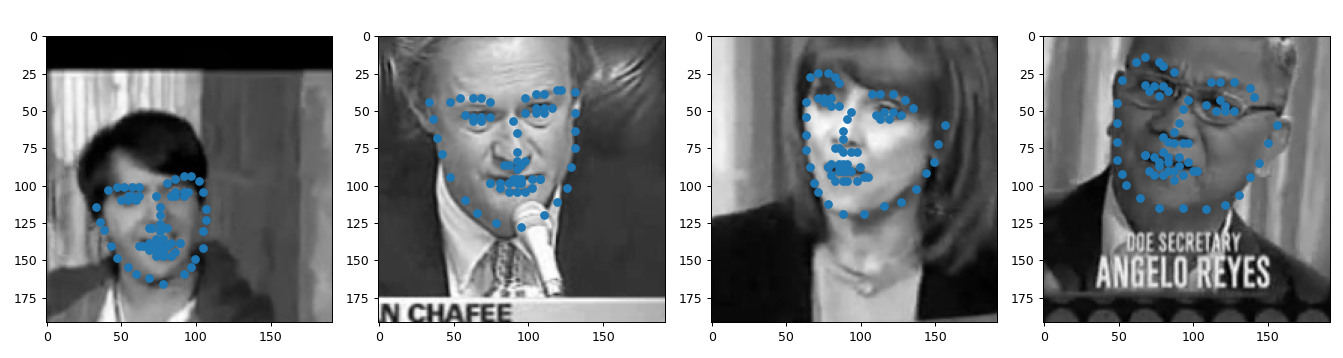

In [6]:
# Visualize training data

fig, axes = plt.subplots(1,4, figsize=(15, 4))
# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    img = sample['image']
    kps = sample['keypoints'].numpy()
    _, h, w = img.shape
    kps = kps*50. + 100.
    axes[i].imshow(sample['image'][0], cmap = 'gray')
    axes[i].scatter(kps.T[0], kps.T[1])
plt.tight_layout()

### Utility functions

In [8]:
def net_sample_output(net, data_loader):
    with torch.no_grad():
        # iterate through the test dataset
        for i, sample in enumerate(data_loader):

            # get sample data: images and ground truth keypoints
            images = sample['image']
            key_pts = sample['keypoints']

            # convert images to FloatTensors
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get net output
            output_pts = net(images)

            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], 68, -1)

            # break after first image is tested
            return images, output_pts, key_pts

def loss_over_full_dataset(net, criterion, data_loader):
    with torch.no_grad():
        values = 0.
        count = 0
        for sample in data_loader:
            images = sample['image']
            key_pts = sample['keypoints']
            images = images.type(torch.cuda.FloatTensor)
            output_pts = net(images).cpu()
            values += criterion(output_pts, key_pts)
            count += 1
        return values/count

In [9]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


In [10]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None):
    batch_size = batch_size_for_display
    num_cols = 6
    num_rows = (batch_size + num_cols-1) // num_cols
    plt.figure(figsize=(num_cols*2,num_rows*2))
    
    for i in range(batch_size):  
        ax = plt.subplot(num_rows, num_cols, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis('off')
    plt.tight_layout()

## Training

In [11]:
import torch.optim as optim

from models import Net

net = Net()
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
net.apply(weights_init)

net.cuda()

Net(
  (initial_stage): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): Re

torch.Size([64, 1, 192, 192])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


<IPython.core.display.Javascript object>


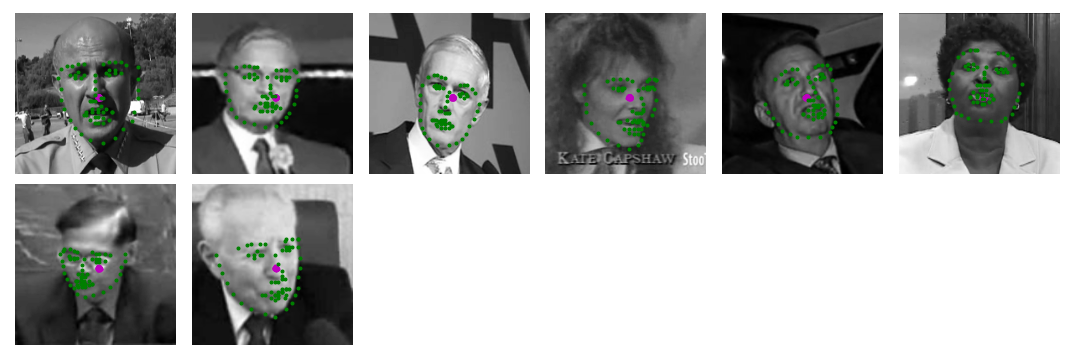

In [13]:
# First check if the network correctly ingests the images
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

visualize_output(test_images, test_outputs, gt_pts)

<IPython.core.display.Javascript object>


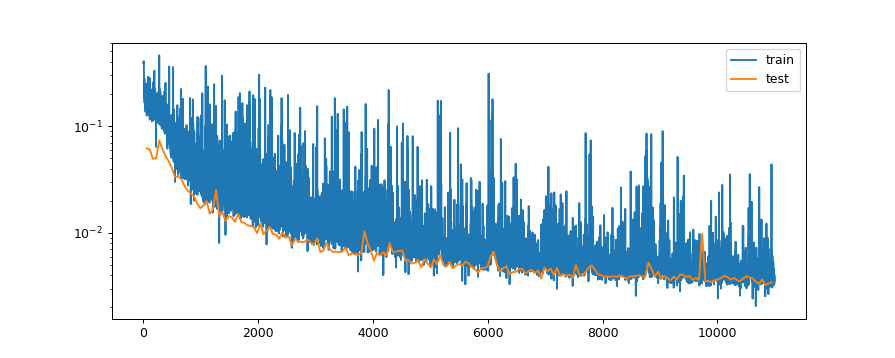

Finished Training


In [14]:
n_epochs = 200
optimizer = optim.Adam(net.parameters(), lr=1.e-4)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
loss_graph_data = []
test_loss_curve = []

progress = ipywidgets.IntProgress(
    value=0,
    min=0,
    max=len(transformed_dataset) // train_loader.batch_size,
    step=1,
)
statustext = ipywidgets.Label("")
display(ipywidgets.HBox([statustext,progress]))


def update_graph():
    ax.clear()
    ax.plot(*np.array(loss_graph_data).T, label='train')
    ax.plot(*np.array(test_loss_curve).T, label='test')
    ax.set(yscale='log')
    ax.legend()
    fig.canvas.draw()

def train_net(n_epochs):
    step = 0
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            loss_graph_data.append((step, loss))
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                descr = 'Epoch: {}, Batch: {}, Avg. Loss: {:.5f}'.format(epoch + 1, batch_i+1, running_loss/10)
                running_loss = 0.0
                progress.value = batch_i
                statustext.value = descr
                update_graph()       
            step += 1
        #scheduler.step()
        test_loss = loss_over_full_dataset(net, criterion, test_loader).detach().numpy()
        test_loss_curve.append((step, test_loss))
    print('Finished Training')

# train your network
train_net(n_epochs)

<IPython.core.display.Javascript object>


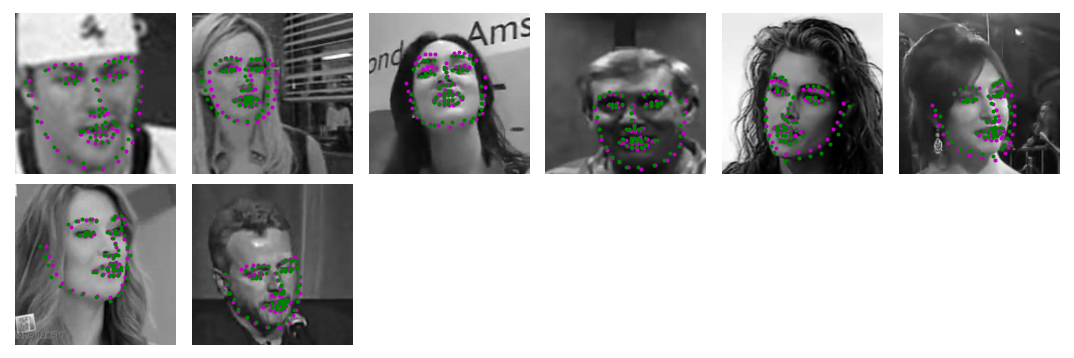

In [15]:
train_images, train_outputs, gt_pts = net_sample_output(net, train_loader)
visualize_output(train_images, train_outputs, gt_pts)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
print (f"Loss over test set = {loss_over_full_dataset(net, criterion, test_loader).detach().numpy()}")

Loss over test set = 0.0037124613754264037


torch.Size([64, 1, 192, 192])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


<IPython.core.display.Javascript object>


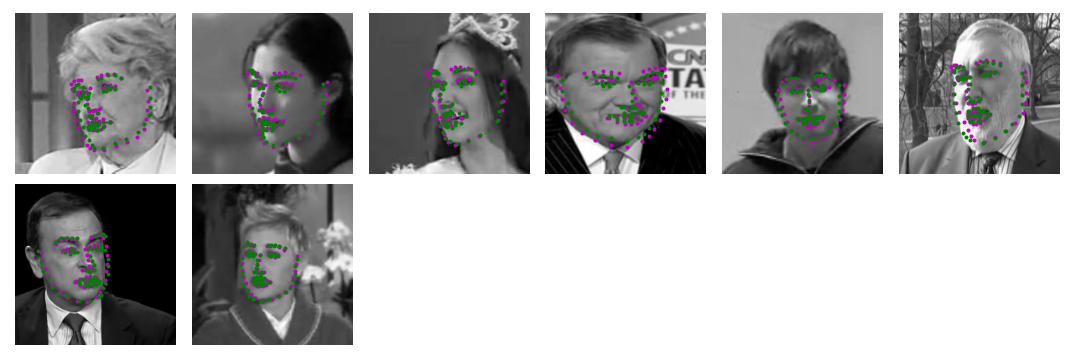

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [19]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_4.pt'

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


* Adam optimizer because it counts as the go to default as I read somewhere. I believe in the deep learning book. I also tried SGD briefly but it did not manage to decrease the loss in a perceivable way.
* I pick mean square loss because we care about getting as close as possible to the ground truth key points. Hence measuring the distance in terms of squared Euclidian distance is very natural. One can also justify it from the view point of a expectancy maximization if one assumes that the data is described by a normal distribution, IIRC. But it is not really necessary. I think L1 normal would also work just fine.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

At first I tried something pretty straight forward like I have now. Except fewer layers. Then tried a ResNetV2-like architecture which did not fit the data well. Maybe has something to do with the padding? Then went back to the straight forward model. Had meanwhile increased the number of dense layers from 1 to 3. Model seems small enough to not overfit. Maybe I should make the network bigger?

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

* I increase the batch size because the loss curve was very noisy. Even noisier than now. I should probably increase it more as my GPU has sufficient memory with the current model.
* I record test and training loss vs the step number. I can keep going as long as the test loss is decreasing or I run out of patience. Should really use a extra validation set for early stopping.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

<IPython.core.display.Javascript object>


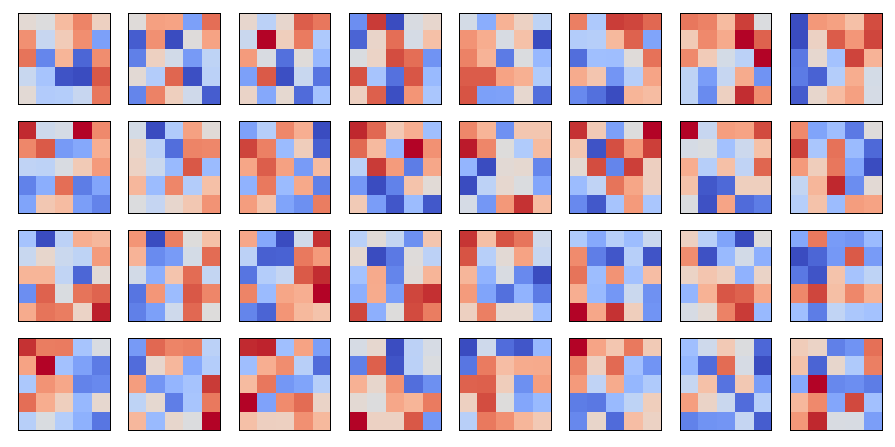

In [20]:
# Visualizing the filters of the first conv layer.

weights1 = net.initial_stage[0].weight.data
w = weights1.cpu().numpy()

fig, axes = plt.subplots(4,8, figsize=(10,5))
axes = axes.ravel()

for i in range(w.shape[0]):
    v = np.amax(np.abs(w[i][0]))
    axes[i].imshow(w[i][0], cmap='coolwarm', vmin=-v, vmax=v)
    axes[i].xaxis.set(visible=False)
    axes[i].yaxis.set(visible=False)

plt.tight_layout()
# This is quite a mess. Hard to tell what these do just by looking at them.

In [21]:
# With this code I'm grabbing a feature map from anywhere in the network and plot it.

def grab_featuremap(net, layer, sample):
    # Do a forward pass and record the activations from the given layer.
    # Takes a data sample and the network as additional input.
    
    featuremap = None # Store the activations.
    def hook(model, input, output):
        # Called with the output of our layer
        nonlocal featuremap
        featuremap = output.detach()
    
    hook = layer.register_forward_hook(hook)
    
    with torch.no_grad():
        image = sample['image']
        key_pts = sample['keypoints']
        # Evaluate the network
        output_pts = net(image[np.newaxis,...].type(torch.cuda.FloatTensor))
    
    # Keep the network clean! So unregister the hook.
    hook.remove()
    
    return featuremap, image, output_pts, key_pts


def display_featuremap(featuremap, image):
    # Display image first. Then all the channels from the feature map.
    # One after another, layed out in a grid.
    num_cols = 6
    num_rows = (featuremap.shape[1]+1+num_cols-1) // num_cols
    fig = plt.figure(figsize=(10,num_rows*2))
    ax = fig.add_subplot(num_rows, num_cols, 1)
    ax.imshow(image[0], cmap='gray')
    ax.set_axis_off()
    for i in range(featuremap.shape[1]):
        ax = fig.add_subplot(num_rows, num_cols, 2+i)
        ax.imshow(featuremap[0,i].cpu(), cmap='coolwarm')
        ax.set_axis_off()
    plt.tight_layout()

<IPython.core.display.Javascript object>


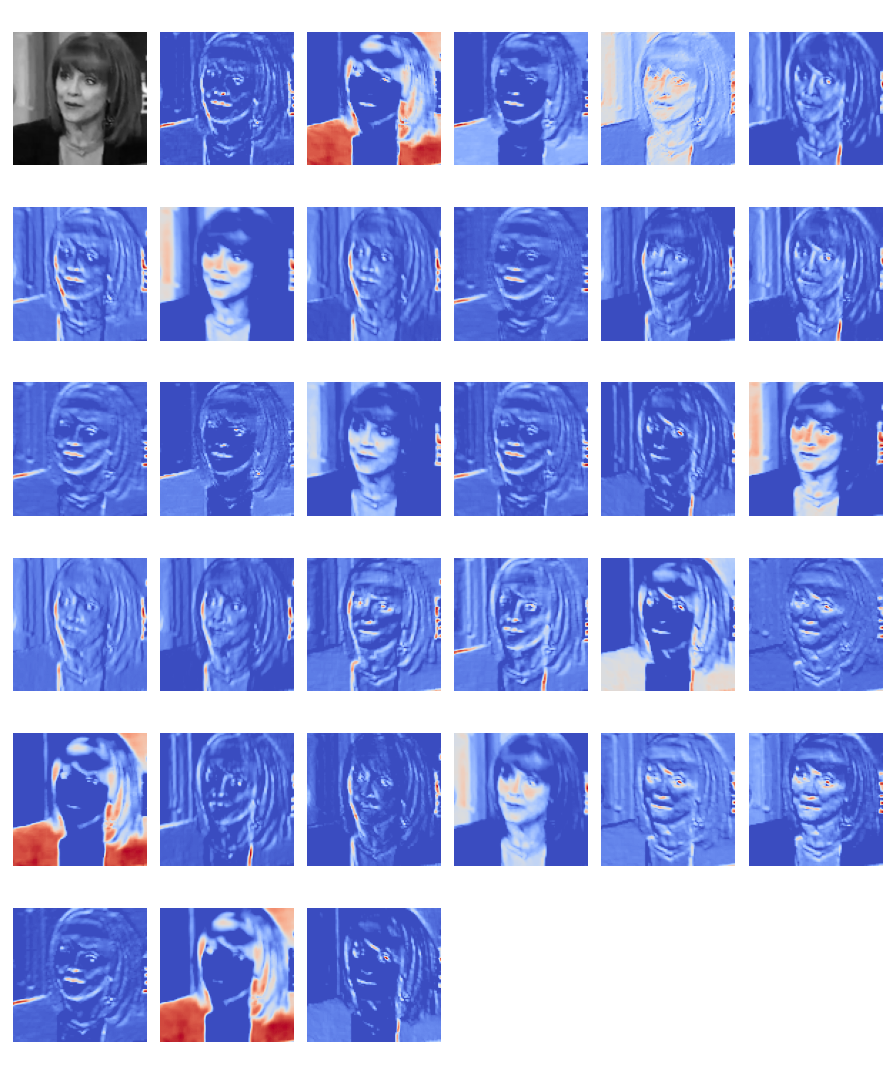

In [22]:
# Show the response of the low level filters.
featuremap, image, _, _ = grab_featuremap(net, net.initial_stage, test_dataset[1])
display_featuremap(featuremap, image)

<IPython.core.display.Javascript object>


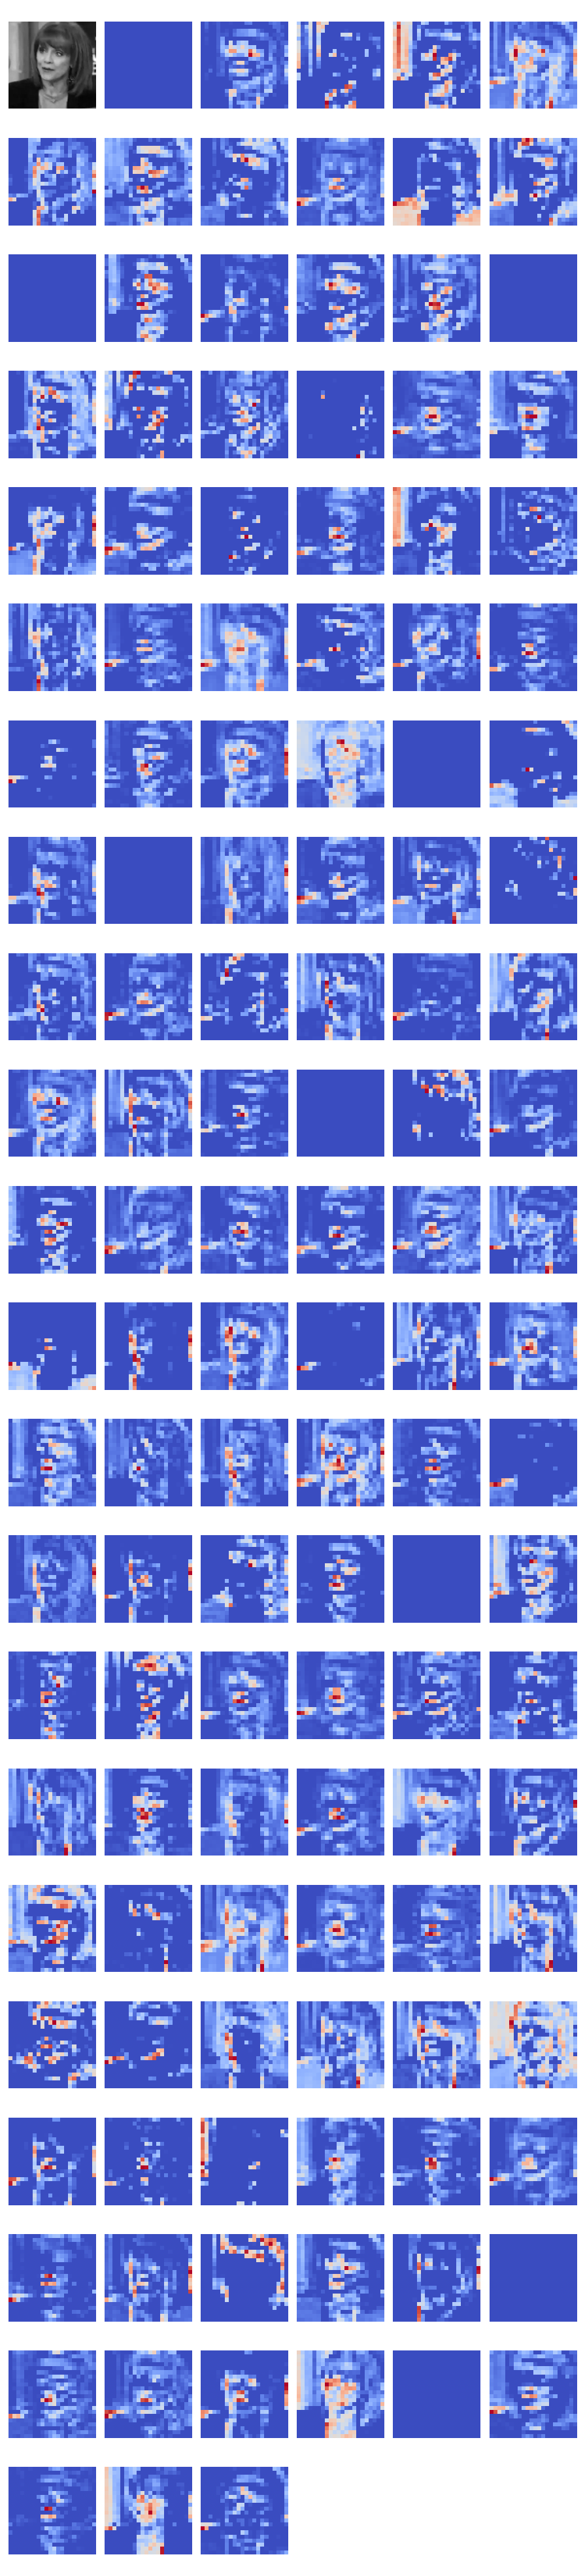

In [23]:
# Show the response of some medium level filters.
featuremap, image, _, _ = grab_featuremap(net, net.convnet[1], test_dataset[1])
display_featuremap(featuremap, image)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


My medium level feature maps show activations for multiple facial features simultaneously. I will pick the following. 
![activation map](images/activation_map.png)
It responds nicely to the nose.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!